# Employee Review Sentiment Analysis with BERT

__author__ = "Fiodar Ryzhykau"
__version__ = "CS224u, Stanford, Fall 2020"

### Project Outline

**Step 1**: Project Introduction

**Step 2**: Exploratory Data Analysis and Preprocessing

**Step 3**: Training/Validation Split

**Step 4**: Loading Tokenizer and Encoding the Data

**Step 5**: Setting up BERT Pretrained Model

**Step 6**: Creating Data Loaders

**Step 7**: Setting Up Optimizer and Scheduler

**Step 8**: Defining the Performance Metrics

**Step 9**: Training the Model

**Step 10**: Result Evaluation

## Step 1: Project Introduction


For my Final Project in the Stanford NLU course I’ve selected a topic that is related to the employee assessment in modern companies. In my current company, every quarter (and annually) managers should provide feedback to their team-members and grade their Performance and Potential in order to objectify the value of that employee to the company. 

We use the “9-box model”, which is also called the “Performance and Potential Model” and has been developed by McKinsey. This approach is used in many companies as a method to identify, support and promote the talent. 

 
Feedback (review) that is being submitted along the 9-box grade should explicitly describe all the strong and weak points of the employee, as well as sentiment to the contribution and progress for the given quarter. Submitted data basically represents a mapping/summarization of the feedback to one of the 9 categories.


Models used:
* [HuggingFace models](https://huggingface.co/transformers/model_doc/bert.html)

* [Bert overview](https://characters.fandom.com/wiki/Bert_(Sesame_Street). 
For more information, the original paper can be found [here](https://arxiv.org/abs/1810.04805). 

## Step 2: Exploratory Data Analysis and Preprocessing

Dataset Has been collected from Amazon MTurk.

In [1]:
from google.colab import drive
from google.colab import auth
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [3]:
pd.set_option('display.max_colwidth', 2000)
df = pd.read_csv('drive/My Drive/Collab_Drive/employee_review_mturk_dataset_13_and_test_v3.1.csv')
df.set_index('id', inplace=True)
df.dropna(inplace=True)

In [4]:
df.head(3)
#df.tail(10)

,person_name,nine_box_category,feedback,performance_class,potential_class,adjusted
id,,,,,,
1,John Doe,"Category 1: 'Risk' (Low performance, Low potential)","John has not progressed in his position. He is continuously late, leaves early, and takes many breaks throughout the day. He calls out at least every other week and it's always on Fridays. His performance has significantly declined. My suggestion is he is not suitable for this position.",1,1,False
2,John Doe,"Category 1: 'Risk' (Low performance, Low potential)","John has consistently disappointed me this quarter with his shoddy work product. I asked him for a report and gave him a lenient two-week deadline, but he blew past that deadline without even informing me. When he finally turned the report in, it was three weeks late and riddled with typos. He did not seem interested in any of the comments that I made on that report, even though I made them for his benefit so he would understand what a high-quality report is supposed to look like.",1,1,False
3,John Doe,"Category 1: 'Risk' (Low performance, Low potential)","John turned in subpar work product all quarter. When I asked him to make revisions, he repeatedly failed to implement the corrections that I had requested. He also seemed confused and lost whenever we had discussions about the reports and the numbers in the data. He was not interested in learning more when I gave him opportunities to participate in trainings. He seems to have already reached his full potential here, which is disappointing given the quality of work I've seen from him.",1,1,False


In [5]:
possible_labels = df.nine_box_category.unique()
possible_labels = np.sort(possible_labels)

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

label_dict_inverse = {v: k for k, v in label_dict.items()}

pp_map = {}
pp_map[0] = [0,0]
pp_map[1] = [1,0]
pp_map[2] = [2,0]
pp_map[3] = [0,1]
pp_map[4] = [1,1]
pp_map[5] = [2,1]
pp_map[6] = [0,2]
pp_map[7] = [1,2]
pp_map[8] = [2,2]

In [6]:
import nltk.data
from nltk import tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
print(f'\nInitial dataset size: {len(df.index)}')

df_upd = df.copy()
df_upd['label'] = df_upd.nine_box_category.replace(label_dict)
df_upd['feedback'] = df_upd.feedback.replace('\\r',' ', regex=True)
df_upd['feedback_len'] = df_upd.feedback.str.len()
df_upd['num_of_sent'] = df_upd.feedback.apply(lambda s: len(tokenize.sent_tokenize(s)))
df_upd['performance_class'] = df_upd.label.apply(lambda l: pp_map[l][0])
df_upd['potential_class'] = df_upd.label.apply(lambda l: pp_map[l][1])

feedback_len_stats = df_upd['feedback_len'].describe(percentiles=[.05,.10,.25,.50,.75,.85,.90,.95])
print(f'\nFeedback len stats: \n{feedback_len_stats}')

num_of_sent_stats = df_upd['num_of_sent'].describe(percentiles=[.05,.10,.25,.50,.75,.85,.90,.95])
print(f'\nFeedback sentence num stats: \n{num_of_sent_stats}')

df_upd = df_upd.loc[(df_upd['feedback_len'] > 150) & (df_upd['feedback_len'] < 600)]
df_upd = df_upd.loc[df_upd['num_of_sent'] > 1]
df_upd = df_upd.loc[~df_upd['feedback'].str.contains('category') & ~df_upd['feedback'].str.contains('Category')]

print(f'\nSize after filtering: {len(df_upd.index)}')

df = df_upd.sort_values(by=['label']).copy()
#df.tail()


Initial dataset size: 923

Feedback len stats: 
count     923.000000
mean      332.780065
std       137.620404
min        59.000000
5%        147.100000
10%       177.000000
25%       237.000000
50%       314.000000
75%       405.000000
85%       480.400000
90%       523.000000
95%       580.900000
max      1060.000000
Name: feedback_len, dtype: float64

Feedback sentence num stats: 
count    923.000000
mean       4.140845
std        1.238259
min        1.000000
5%         2.000000
10%        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
85%        5.000000
90%        5.000000
95%        6.000000
max       24.000000
Name: num_of_sent, dtype: float64

Size after filtering: 803


In [8]:
#bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
res = df_upd['feedback_len'].value_counts(bins=10, sort=False)
print(f'\nDistribution by len in filtered: \n{res}')


Distribution by len in filtered: 
(150.553, 195.6]     71
(195.6, 240.2]      101
(240.2, 284.8]      136
(284.8, 329.4]      128
(329.4, 374.0]      106
(374.0, 418.6]       90
(418.6, 463.2]       55
(463.2, 507.8]       48
(507.8, 552.4]       38
(552.4, 597.0]       30
Name: feedback_len, dtype: int64


In [9]:
df.performance_class.value_counts().sort_index()

0    271
1    261
2    271
Name: performance_class, dtype: int64

In [10]:
df.potential_class.value_counts().sort_index()

0    294
1    263
2    246
Name: potential_class, dtype: int64

In [11]:
df.nine_box_category.value_counts()

Category 1: 'Risk' (Low performance, Low potential)                        103
Category 3: 'Solid Performer' (High performance, Low potential)            101
Category 5: 'Core Player' (Moderate performance, Moderate potential)        95
Category 9: 'Star' (High performance, High potential)                       92
Category 4: 'Inconsistent Player' (Low performance, Moderate potential)     90
Category 2: 'Average performer' (Moderate performance, Low potential)       90
Category 7: 'Potential Gem' (Low performance, High potential)               78
Category 6: 'High Performer' (High performance, Moderate potential)         78
Category 8: 'High Potential' (Moderate performance, High potential)         76
Name: nine_box_category, dtype: int64

## Step 3: Training/Validation Split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [14]:
df['data_type'] = ['not_set']*df.shape[0]

In [15]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [16]:
df.groupby(['nine_box_category', 'label', 'data_type']).count()
pass

## Step 4: Loading Tokenizer and Encoding the Data

In [17]:
!pip install transformers
pass

In [18]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [19]:
#bert_type = 'bert-base-cased'
bert_type = 'bert-large-uncased'
convert_to_lowercase=True
tokenizer = BertTokenizer.from_pretrained(bert_type, 
                                          do_lower_case=convert_to_lowercase)

In [20]:
tensor_size=512

train_df = df[df.data_type=='train']

encoded_data_train = tokenizer.batch_encode_plus(
    train_df.feedback.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=tensor_size, 
    return_tensors='pt',
    truncation=True
)

val_df = df[df.data_type=='val']

encoded_data_val = tokenizer.batch_encode_plus(
    val_df.feedback.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=tensor_size, 
    return_tensors='pt',
    truncation=True
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_df.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val_df.label.values)

In [21]:
train_df.to_csv('train_set.csv')
val_df.to_csv('validation_set.csv')

In [22]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [23]:
print(f'Dataset size full     : {len(dataset_train) + len(dataset_val)}')
print(f'Dataset for training  : {len(dataset_train)}')
print(f'Dataset for validation: {len(dataset_val)}')

Dataset size full     : 803
Dataset for training  : 682
Dataset for validation: 121


## Step 5: Setting up BERT Pretrained Model

In [24]:
from transformers import BertForSequenceClassification

In [25]:
print(f'Num of labels:{len(label_dict)}')
model = BertForSequenceClassification.from_pretrained(bert_type,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



Num of labels:9


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

## Step 6: Creating Data Loaders

In [26]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [27]:
batch_size = 4 #large_bert
#batch_size = 16 #base_bert

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

## Step 7: Setting Up Optimiser and Scheduler

In [28]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [29]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [30]:
#epochs = 40 #base_bert
epochs = 15 #large_bert

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Step 8:Defining the Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [31]:
from sklearn.metrics import f1_score

In [32]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


In [33]:
def get_dataset_id_label_map(input_df):
    labels = input_df.label.unique()
    #print(labels)
    result_map = dict()
    for label in labels:
        rows_with_labels = input_df.loc[input_df['label'] == label]
        ids = rows_with_labels.index
        #print(f'Label {label} ids: {ids}')
        result_map[label] = ids.copy()
    return result_map

#print(get_dataset_id_label_map(test_df))

In [34]:
def calculate_stats_per_class(preds, labels, input_df=pd.DataFrame()):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    total_correct = 0
    overall_gold = 0
    id_map = get_dataset_id_label_map(input_df)   
    output_df  = input_df.copy()    
    all_predictions = np.array([])
    

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]  
        print(f'Class: {label_dict_inverse[label]}')

        all_predictions = np.concatenate((all_predictions, y_preds), axis=0)

        correct = len(y_preds[y_preds==label])
        total_correct += correct
        num_of_gold = len(y_true)
        overall_gold += num_of_gold

        print(f'Predictions: {y_preds}')
        print(f'Gold Values: {y_true}')
        print(f'Ids: {id_map[label]}')
       
        print(f'Accuracy: {correct} / {num_of_gold}\n')  

    print(f'Total Correct/Gold: {total_correct}/{overall_gold}\n')
    print(f'AVG Accuracy: {total_correct / overall_gold}\n')

    output_df['ml_prediction_label'] = pd.Series(all_predictions, index=output_df.index)
    output_df['ml_category'] = output_df.ml_prediction_label.apply(lambda l: label_dict_inverse[l])
    output_df['ml_performance_class'] = output_df.ml_prediction_label.apply(lambda l: pp_map[l][0])
    output_df['ml_potential_class'] = output_df.ml_prediction_label.apply(lambda l: pp_map[l][1])
    output_df['ml_match'] = output_df.apply(lambda row: row.label == row.ml_prediction_label, axis=1)
    output_df['performance_match'] = output_df.apply(lambda row: row.performance_class == row.ml_performance_class, axis=1)
    output_df['potential_match'] = output_df.apply(lambda row: row.potential_class == row.ml_potential_class, axis=1)
    
    return output_df

## Step 9: Training the Model

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [35]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [36]:
import os
if not os.path.exists('trained_models'):
    os.makedirs('trained_models')
if not os.path.exists('stats'):
    os.makedirs('stats')
if not os.path.exists('analysis'):
    os.makedirs('analysis')

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [37]:
def evaluate(dataloader_values, target_model):

    target_model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_values:
        #print(f'batch {batch.size()}')
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }
        #print(f'input_ids: {batch[0]}')
        #print(f'labels: {batch[2]}')
        with torch.no_grad():        
            outputs = target_model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        #print(f'logits {logits}')
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_values) 

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [38]:
epoch_list = []
train_loss = []
validation_loss = []
f1_scores_weighted = []
#min_epoch_to_save = 30 #base_bert
min_epoch_to_save = 5 #large_bert


for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        #print(f'batch[0] - input_ids: {batch[0].size()}' )
        #print(f'batch[1] - attention_mask: {batch[1].size()}' )
        #print(f'batch[2] - labels: {batch[2].size()}' )
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        #print(f'loss {loss}')
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)             
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation, model)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

    epoch_list.append(epoch)
    train_loss.append(loss_train_avg)
    validation_loss.append(val_loss)
    f1_scores_weighted.append(val_f1)

    if (epoch > min_epoch_to_save):    
        torch.save(model.state_dict(), f'trained_models/finetuned_BERT_epoch_{epoch}.model')

        df_learning_curve = pd.DataFrame({'epoch': epoch_list,
                      'train_loss_avg': train_loss,
                      'validation_loss': validation_loss,
                      'val_f1_weighted': f1_scores_weighted})

        lc_file_name = f'stats/learning_curve_{epoch}.csv'
        df_learning_curve.to_csv(lc_file_name, index=False)



Epoch 1
Training loss: 2.18877621282611
Validation loss: 1.939520905094762
F1 Score (Weighted): 0.19759906000375208



Epoch 2
Training loss: 1.8230909583164236
Validation loss: 1.698469392714962
F1 Score (Weighted): 0.2730185724741078



Epoch 3
Training loss: 1.394177810839045
Validation loss: 1.2859844459641365
F1 Score (Weighted): 0.5153103200264931



Epoch 4
Training loss: 0.8442353024991632
Validation loss: 1.1978151841509728
F1 Score (Weighted): 0.5656668002854324



Epoch 5
Training loss: 0.4365049971823107
Validation loss: 1.0159158802801562
F1 Score (Weighted): 0.6907971013211684



Epoch 6
Training loss: 0.18218458184634734
Validation loss: 1.0533384481264698
F1 Score (Weighted): 0.6835418950188771



Epoch 7
Training loss: 0.06718583274033596
Validation loss: 1.175573863532214
F1 Score (Weighted): 0.7421282156925985



Epoch 8
Training loss: 0.026683108430432034
Validation loss: 1.2621427941842065
F1 Score (Weighted): 0.7461787280933755



Epoch 9
Training loss: 0.012330130078933306
Validation loss: 1.2984715770975115
F1 Score (Weighted): 0.7415602751195



Epoch 10
Training loss: 0.00421136084124337
Validation loss: 1.2884812379563828
F1 Score (Weighted): 0.7686378497275982



Epoch 11
Training loss: 0.0027931191010825466
Validation loss: 1.3215059801267701
F1 Score (Weighted): 0.7444535265742844



Epoch 12
Training loss: 0.00246654581401105
Validation loss: 1.3372626091041904
F1 Score (Weighted): 0.7605960401871539



Epoch 13
Training loss: 0.0017624196299618623
Validation loss: 1.3772556894316128
F1 Score (Weighted): 0.7607555242025031



Epoch 14
Training loss: 0.001509802393500873
Validation loss: 1.3721109706037227
F1 Score (Weighted): 0.7693241935417254



Epoch 15
Training loss: 0.0014503695937390956
Validation loss: 1.3777890501585188
F1 Score (Weighted): 0.7611783999413865



## Step 10: Result Evaluation

In [46]:
#Preparing Test Set
test_df = pd.read_csv(f'drive/My Drive/Collab_Drive/employee_review_mturk_dataset_test_batch_2_v1.csv')
val_r = test_df.loc[test_df['id'] == 20086].feedback
#print(val_r)
#print(val_r.str.replace(r'\r',' '))

test_df.set_index('id', inplace=True)
test_df.dropna(inplace=True)

test_df['feedback'] = test_df.feedback.replace('\\r',' ', regex=True)
test_df['label'] = test_df.nine_box_category.replace(label_dict)
test_df['performance_class'] = test_df.label.apply(lambda l: pp_map[l][0])
test_df['potential_class'] = test_df.label.apply(lambda l: pp_map[l][1])
test_df = test_df.sort_values(by=['label'])
test_df.to_csv(f'test_set.csv')
#test_df.head()


In [40]:
print(f'Test Set size: {len(test_df)}')
print(f'Num of Test Classes: {test_df.nine_box_category.value_counts()}')

tensor_size=512

encoded_data_test = tokenizer.batch_encode_plus(
    test_df.feedback.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=tensor_size, 
    return_tensors='pt',
    truncation=True
)


input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_df.label.values)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

Test Set size: 233
Num of Test Classes: Category 5: 'Core Player' (Moderate performance, Moderate potential)       30
Category 2: 'Average performer' (Moderate performance, Low potential)      28
Category 3: 'Solid Performer' (High performance, Low potential)            27
Category 1: 'Risk' (Low performance, Low potential)                        27
Category 4: 'Inconsistent Player' (Low performance, Moderate potential)    26
Category 8: 'High Potential' (Moderate performance, High potential)        25
Category 6: 'High Performer' (High performance, Moderate potential)        24
Category 9: 'Star' (High performance, High potential)                      24
Category 7: 'Potential Gem' (Low performance, High potential)              22
Name: nine_box_category, dtype: int64


In [42]:
#print(f'Num of classes {len(label_dict)}')
eval_model = BertForSequenceClassification.from_pretrained(bert_type,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

eval_model.to(device)
pass

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [43]:
#eval_model_path = f'drive/My Drive/Collab_Drive/v3.1/finetuned_BERT_epoch_50.model'
eval_model_path = f'trained_models/finetuned_BERT_epoch_15.model'
#eval_model_path = f'trained_models/finetuned_BERT_epoch_{epochs}.model'
eval_model.load_state_dict(torch.load(eval_model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [44]:
_, val_predictions, true_val_vals = evaluate(dataloader_validation, eval_model)
output_val_df = calculate_stats_per_class(val_predictions, true_val_vals, val_df)
output_val_df.to_csv('analysis/validation_set_analysis.csv')

Class: Category 1: 'Risk' (Low performance, Low potential)
Predictions: [0 3 0 0 0 0 0 0 3 0 0 0 0 0 3]
Gold Values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ids: Int64Index([87, 82, 81, 72, 70, 65, 10046, 10126, 10005, 10168, 10169, 25, 13,
            53, 51],
           dtype='int64', name='id')
Accuracy: 12 / 15

Class: Category 2: 'Average performer' (Moderate performance, Low potential)
Predictions: [1 1 7 3 5 1 1 6 1 1 1 1 1 1]
Gold Values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Ids: Int64Index([10212, 10132, 10131, 10130, 10007, 127, 116, 106, 101, 94, 133,
            129, 151, 138],
           dtype='int64', name='id')
Accuracy: 10 / 14

Class: Category 3: 'Solid Performer' (High performance, Low potential)
Predictions: [5 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Gold Values: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Ids: Int64Index([10054, 261, 10011, 220, 223, 225, 236, 239, 243, 249, 216, 181,
            188, 192, 204],
           dtype='int64', name='id')
Accuracy: 14 / 15

Class: Category 4: 'Inconsistent Pla

In [47]:
_, test_predictions, true_test_vals = evaluate(dataloader_test, eval_model)
output_test_df = calculate_stats_per_class(test_predictions, true_test_vals, test_df)
output_test_df.to_csv('analysis/test_set_analysis.csv')


Class: Category 1: 'Risk' (Low performance, Low potential)
Predictions: [0 0 3 3 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 3 0 3]
Gold Values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Ids: Int64Index([20001, 20212, 20043, 20044, 20045, 20046, 20047, 20127, 20173,
            20172, 20171, 20170, 20085, 20086, 20087, 20088, 20089, 20130,
            20129, 20128, 20213, 20214, 20126, 20005, 20004, 20003, 20002],
           dtype='int64', name='id')
Accuracy: 22 / 27

Class: Category 2: 'Average performer' (Moderate performance, Low potential)
Predictions: [4 5 0 1 1 1 4 2 1 1 1 1 1 2 4 4 1 1 0 3 4 3 4 1 4 1 1 3]
Gold Values: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Ids: Int64Index([20176, 20050, 20051, 20090, 20177, 20175, 20174, 20010, 20094,
            20093, 20092, 20009, 20008, 20007, 20006, 20049, 20048, 20091,
            20133, 20131, 20215, 20135, 20134, 20219, 20218, 20217, 20132,
            20216],
           dtype='int64', name='id')
Accuracy: 

In [ ]:
#for data cleanup
#_, train_predictions, true_train_vals = evaluate(dataloader_train, eval_model)
#output_train_df = calculate_stats_per_class(train_predictions, true_train_vals, train_df)
#output_train_df.to_csv('analysis/train_set_analysis.csv')

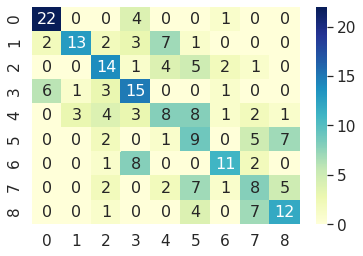

In [48]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

def confusion_matrix_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    unique_labels = np.unique(labels_flat)
    return confusion_matrix(labels_flat, preds_flat, labels=unique_labels)


cm = confusion_matrix_func(test_predictions, true_test_vals)

sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cmap="YlGnBu") # font size

plt.show()

In [49]:
# Drawing the result Plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter

lc_file_name = f'stats/learning_curve_{epochs}.csv';

df_learning_curve = pd.read_csv(lc_file_name)

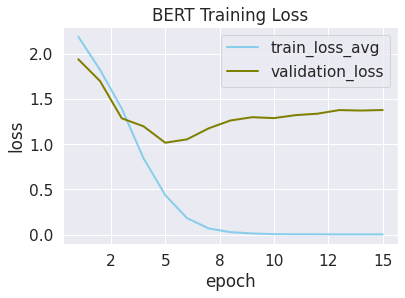

In [50]:
# Training loss plot

plt.plot( 'epoch', 'train_loss_avg', data=df_learning_curve,   color='skyblue', linewidth=2, label="train_loss_avg")
plt.plot( 'epoch', 'validation_loss', data=df_learning_curve,  color='olive', linewidth=2, label="validation_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('BERT Training Loss') 
plt.grid(True) 
#plt.ylim(0, 2.5)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.show() 

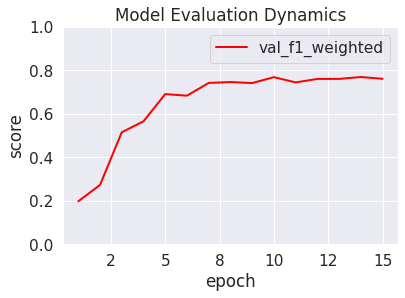

In [51]:
# Training Evaluation Dynamics plot
plt.plot( 'epoch', 'val_f1_weighted', data=df_learning_curve,  color='red', linewidth=2,  label="val_f1_weighted")
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()
plt.title('Model Evaluation Dynamics') 
plt.grid(True) 
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.ylim(0, 1)
plt.show() 